<a href="https://colab.research.google.com/github/rastringer/blog_notebooks/blob/main/ai_safety.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Safety

It's no secret that advances in AI are steaming forward at a pace of innovation and technical progress rarely seen in human history. If we propagate forwards the advances of the past 6-7 years, including transformer models to LLMs and GPT et al., it can be hard to fathom what will be possible in the near future.

The undeniably powerful technology is progressing faster than researchers, engineers and policy makers are able to decide how best to keep AI applications safe and how to restrict their potential harm. Such preventative measures can include bans on certain applications (surveillance and weapons, for example) to alerting systems to warn humans when models transgress the borders of their original tasks and any specified ethical boundaries, and to programming guardrails to prevent such eventualities in the first place.

It's unsurprising therefore that AI Safety is a growing field of research to understand:

* How neural networks work at the level of neurons or nodes
* Why they make their predictions
* What can go wrong when they act in unintended or harmful way
* How we can program guardrails to ensure they stay on track

### Notebook 1

This will be the first notebook in a series to experiment with the basics  of AI safety research.

A good place to start with AI safety is to find ways to observe the inner workings of a neural net. There are two key angles to doing so; observing the weights and activations.

Weights concern the numerical values a model learns to adjust based on its inputs; activations are the values generated by each node in a forward pass, representing the level of 'activation', or strength, of a particular feature (the square footage of houses; the lines of cat's ears; the pitch of a birdsong).

As a simple example with which to get started, we will study a simple convolutional neural network used for an image classification task.

### Set up the convolutional neural net

Here's our simple convolutional neural network in PyTorch which we will use for some investigations on the MNIST dataset of hand-drawn numbers, 0-9. It consists of:
* Two convolutional layers (`conv1` and `conv2`)
* Each conv layer is followed by rectified linear unit (ReLU) activation functions `relu1` and `relu2`
* Max pooling layers follow the activations to extract and downsample features from the input images
* Two fully connected layers `fc1` and `fc2` with another activation function `relu3`, the final of which outputs a 10-dimensional vector indicating the prediction for classification tasks.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        # Activation
        self.relu1 = nn.ReLU()
        # Max pooling
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Second convolutional layer etc
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    # Forward pass
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

# Set up for GPU / CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel()
model = model.to(device)

To better visualize the model architecture, we can use `torchsummary` to print out our layers

In [2]:
from torchsummary import summary

summary(model, (1, 28, 28))  # Assuming input image size is (1, 28, 28)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 128]         401,536
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.65
Params size (MB): 1.61
Estimated Total Size (MB): 2.26
-------------------------------------------

Better still, we can use the `torchviz` library to visualize the various building blocks of the network.

In [ ]:
! pip install torchviz

In [5]:
from torchviz import make_dot

# Same size as input data
dummy_input = torch.randn(1, 1, 28, 28).cuda()

graph = make_dot(model(dummy_input), params=dict(model.named_parameters()))
graph.render("CNNModel", format="png", cleanup=True)

'CNNModel.png'

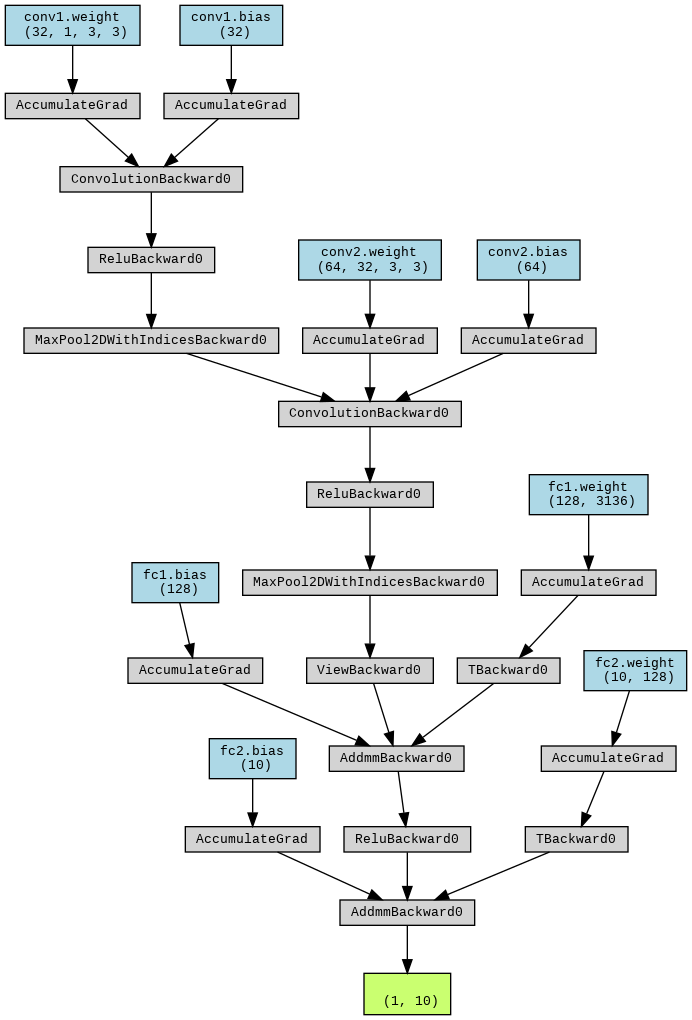

In [6]:
from IPython.display import Image, display

# Display the image in the notebook
image_path = "CNNModel.png"
display(Image(filename=image_path))


### Loading the dataset using torchvision

In [11]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

In [ ]:
# Set up for GPU / CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
model = CNNModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training loop

Here, we run through the entire dataset for `num_epochs` times and calculate the loss, gradients and weight updates.

In [15]:
# Training loop
def train(num_epochs):

  for epoch in range(num_epochs):
      total_loss = 0.0
      correct = 0
      total = 0
      for i, (images, labels) in enumerate(train_loader):
          images, labels = images.to(device), labels.to(device)  # Move data to GPU if available
          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          total_loss += loss.item()
          _, predicted = outputs.max(1)
          total += labels.size(0)
          correct += predicted.eq(labels).sum().item()

      # Print results at the end of each epoch
      avg_loss = loss / len(train_loader)
      accuracy = 100 * correct / total
      print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}")

train(5)

Epoch 1/5, Loss: 0.0002, Accuracy: 99.48
Epoch 2/5, Loss: 0.0000, Accuracy: 99.59
Epoch 3/5, Loss: 0.0000, Accuracy: 99.67
Epoch 4/5, Loss: 0.0000, Accuracy: 99.72
Epoch 5/5, Loss: 0.0000, Accuracy: 99.78


### Displaying the activations

The activations show us the importance the model is assigning to different features, which in this case means darker and lighter parts of the image, or curves of drawn numerals.

## Hooks

Hooks are an interesting technique to employ callbacks to capture activations from the training and query what they have been up to.

In the code below, we use `registered_forward_hook`, which is a PyTorch method to place a hook on a model. This method tags each layer with a forward hook, allowing us to output the activations for each layer to the `activations` list.

### The ?? plugin

If ever a method looks unfamilar, you can type the it along with `??` to see the source code.

In [25]:
model.children??

Output:
```
Signature: model.children() -> Iterator[ForwardRef('Module')]
Source:   
    def children(self) -> Iterator['Module']:
        r"""Returns an iterator over immediate children modules.

        Yields:
            Module: a child module
        """
        for name, module in self.named_children():
            yield module
File:      /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py
Type:      method
```

In [18]:
# Visualization of activations
def plot_activations(model, input_tensor):
    activations = []

    # Register hooks to capture activations
    def hook_fn(module, input, output):
        activations.append(output)

    hooks = []
    for layer in model.children():
        hook = layer.register_forward_hook(hook_fn)
        hooks.append(hook)

    # Forward pass to capture activations
    with torch.no_grad():
        model(input_tensor)

    # Determine the number of rows and cols for the plot
    num_layers = len(activations)
    num_columns = min(3, num_layers)  # Display up to 3 activations per row
    num_rows = (num_layers + num_columns - 1) // num_columns

    # Plot the activations in a grid
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 3 * num_rows))

    for i, (activation, ax) in enumerate(zip(activations, axes.flatten())):
        if len(activation.size()) == 4:  # Check if it's a 4D tensor (activation map)
            ax.imshow(activation[0, 0].cpu().numpy(), cmap='viridis')
            ax.set_title(f'Layer {i+1} Activation')
            ax.axis('off')

    # Remove empty subplots
    for j in range(num_layers, num_rows * num_columns):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

    # Remove hooks
    for hook in hooks:
        hook.remove()



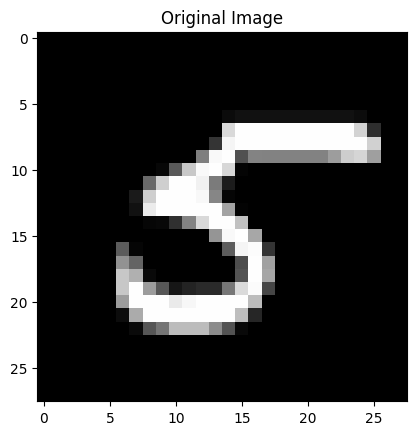

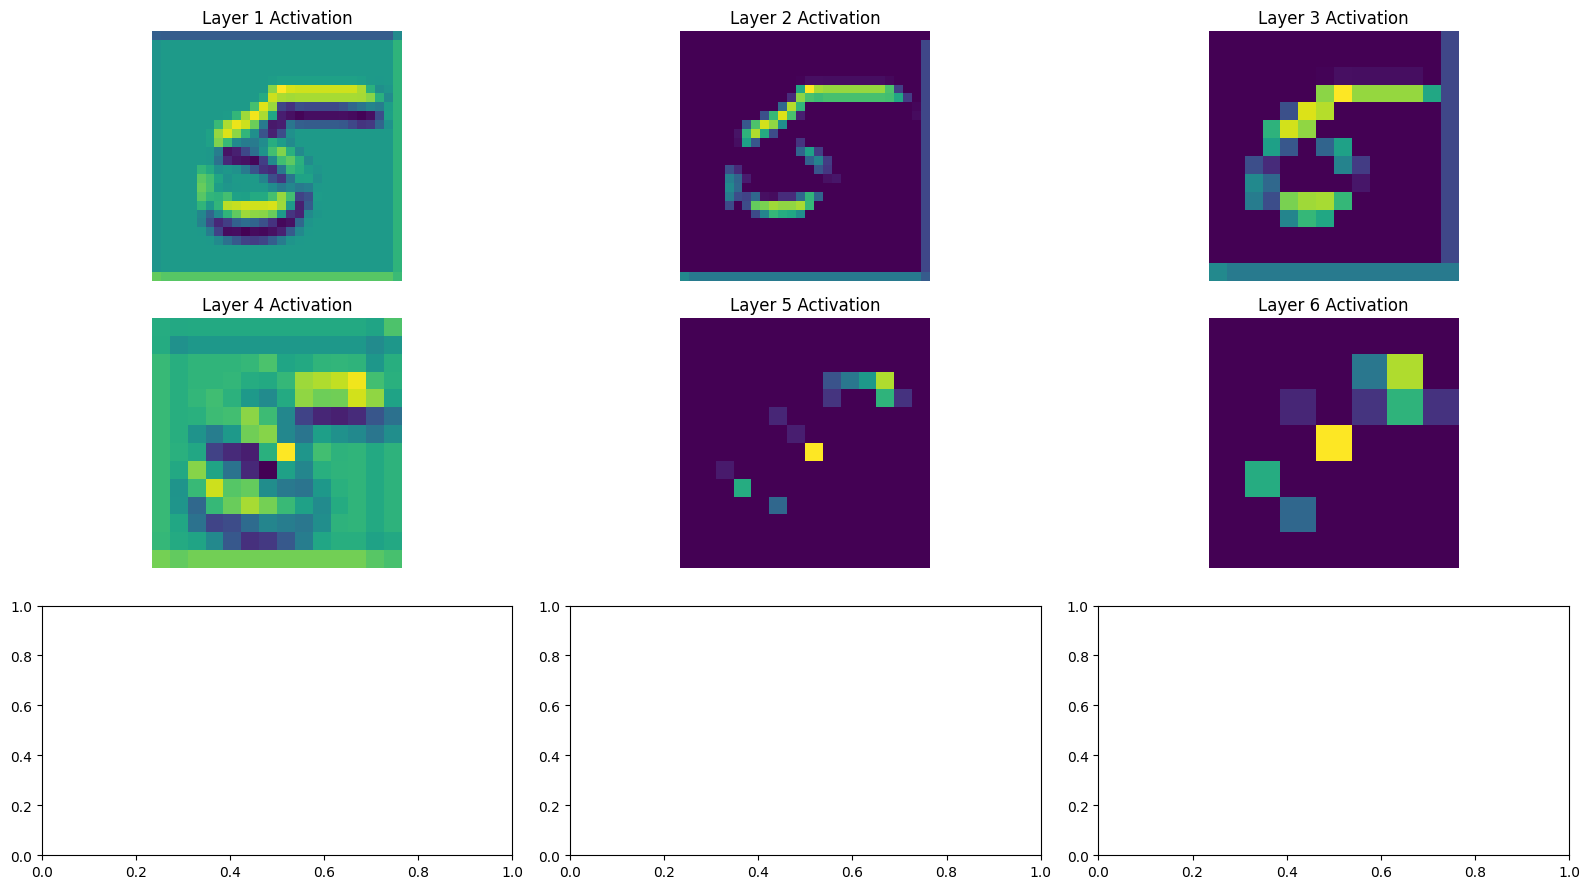

In [26]:
# Random image from the dataset for visualization
sample_image, _ = train_dataset[np.random.randint(len(train_dataset))]
sample_image = sample_image.unsqueeze(0)  # Add batch dimension
sample_image = sample_image.to(device)

# Display the original image
plt.imshow(sample_image[0, 0].cpu().numpy(), cmap='gray')
plt.title('Original Image')
plt.show()

# Display the activations
plot_activations(model, sample_image)

Notice how the activations become more abstract and high-level with each passing layer. The early layers notice the low-level features such as edges and simple patterns (they look closer to the selected numeral). The deeper layers progress into more abstract features such as concentrations of pixels at specific regions of the image.

### Plotting the weights

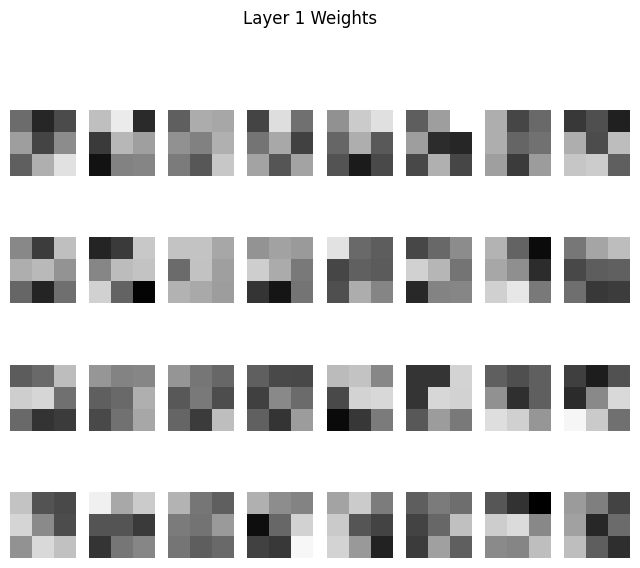

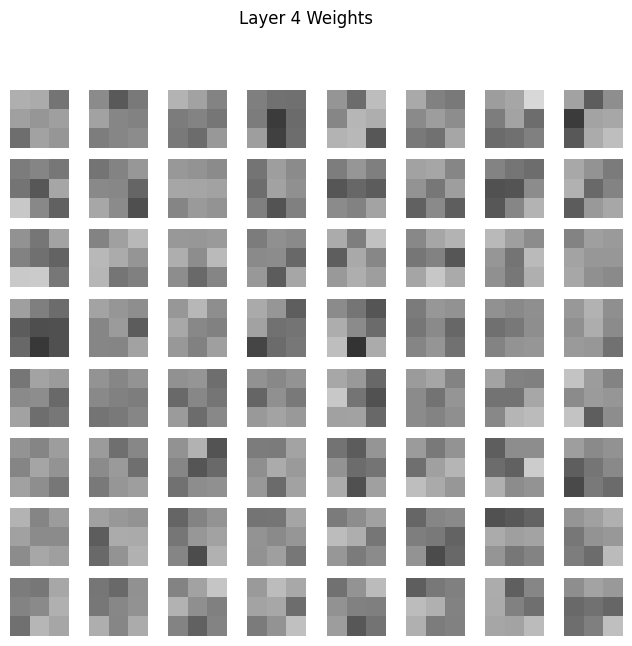

In [24]:
# Display weights
def plot_weights(model):
    conv_layers = [layer for layer in model.children() if isinstance(layer, nn.Conv2d)]
    for i, layer in enumerate(conv_layers):
        plt.figure(figsize=(8, 8))
        weights = layer.weight.data.cpu().numpy()  # Move weights to CPU for visualization
        min_val, max_val = np.min(weights), np.max(weights)
        num_filters = weights.shape[0]
        for j in range(num_filters):
            plt.subplot(num_filters//8 + 1, 8, j+1)
            plt.imshow(weights[j, 0], cmap='gray', vmin=min_val, vmax=max_val)
            plt.axis('off')
        plt.suptitle(f'Layer {i*3 + 1} Weights')  # Adjust layer index
        plt.show()

# Display weights of convolutional layers
plot_weights(model)